<a href="https://colab.research.google.com/github/holguinmora123/OpenAi_Codex/blob/main/5_4_MetaApi_Conda_Kal_Optimize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install ta-lib

In [ ]:
!pip install --upgrade metaapi-cloud-sdk pandas

In [ ]:
import talib as ta
print(ta.__version__)  # Should print something like 0.4.28
print(ta.ATR.__doc__)  # Confirm ATR function works
ta.ATR

0.6.7
ATR(ndarray high, ndarray low, ndarray close, int timeperiod=-0x80000000)

ATR(high, low, close[, timeperiod=?])

Average True Range (Volatility Indicators)

Inputs:
    prices: ['high', 'low', 'close']
Parameters:
    timeperiod: 14
Outputs:
    real


<function talib._ta_lib.ATR(high, low, close, timeperiod=-2147483648)>

In [ ]:
import numpy as np
import pandas as pd
import os
import datetime as dt
import logging

from typing import Sequence, Tuple, Dict, Any, List, Callable, Optional

import random
import asyncio

from metaapi_cloud_sdk import MetaApi
from metaapi_cloud_sdk.clients.timeout_exception import TimeoutException
from typing import Sequence, Tuple

import nest_asyncio
nest_asyncio.apply()

import json, re, traceback, requests

import sys
sys.path.append("..")

import warnings
warnings.filterwarnings('ignore')

from __future__ import annotations

try:
    from metaapi_cloud_sdk import MetaApi
except Exception:
    MetaApi = None  # permite importar el módulo incluso sin el SDK instalado


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn-v0_8-darkgrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set_Up

In [ ]:
process = 'Train'
SYMBOL = 'XAUUSD'

root_data = f'/content/drive/MyDrive/Course Folder/Forex/{SYMBOL}/'
print(root_data)

rolling_window = 100

FILE_PATH = 'xauusd_data.csv'

META_API_TOKEN = 'eyJhbGciOiJSUzUxMiIsInR5cCI6IkpXVCJ9.eyJfaWQiOiJhOGYxYmQ1ZTY2YzlhYWYxYzM4ZjVjMmI0MGFhZjMwYyIsImFjY2Vzc1J1bGVzIjpbeyJpZCI6InRyYWRpbmctYWNjb3VudC1tYW5hZ2VtZW50LWFwaSIsIm1ldGhvZHMiOlsidHJhZGluZy1hY2NvdW50LW1hbmFnZW1lbnQtYXBpOnJlc3Q6cHVibGljOio6KiJdLCJyb2xlcyI6WyJyZWFkZXIiLCJ3cml0ZXIiXSwicmVzb3VyY2VzIjpbIio6JFVTRVJfSUQkOioiXX0seyJpZCI6Im1ldGFhcGktcmVzdC1hcGkiLCJtZXRob2RzIjpbIm1ldGFhcGktYXBpOnJlc3Q6cHVibGljOio6KiJdLCJyb2xlcyI6WyJyZWFkZXIiLCJ3cml0ZXIiXSwicmVzb3VyY2VzIjpbIio6JFVTRVJfSUQkOioiXX0seyJpZCI6Im1ldGFhcGktcnBjLWFwaSIsIm1ldGhvZHMiOlsibWV0YWFwaS1hcGk6d3M6cHVibGljOio6KiJdLCJyb2xlcyI6WyJyZWFkZXIiLCJ3cml0ZXIiXSwicmVzb3VyY2VzIjpbIio6JFVTRVJfSUQkOioiXX0seyJpZCI6Im1ldGFhcGktcmVhbC10aW1lLXN0cmVhbWluZy1hcGkiLCJtZXRob2RzIjpbIm1ldGFhcGktYXBpOndzOnB1YmxpYzoqOioiXSwicm9sZXMiOlsicmVhZGVyIiwid3JpdGVyIl0sInJlc291cmNlcyI6WyIqOiRVU0VSX0lEJDoqIl19LHsiaWQiOiJtZXRhc3RhdHMtYXBpIiwibWV0aG9kcyI6WyJtZXRhc3RhdHMtYXBpOnJlc3Q6cHVibGljOio6KiJdLCJyb2xlcyI6WyJyZWFkZXIiLCJ3cml0ZXIiXSwicmVzb3VyY2VzIjpbIio6JFVTRVJfSUQkOioiXX0seyJpZCI6InJpc2stbWFuYWdlbWVudC1hcGkiLCJtZXRob2RzIjpbInJpc2stbWFuYWdlbWVudC1hcGk6cmVzdDpwdWJsaWM6KjoqIl0sInJvbGVzIjpbInJlYWRlciIsIndyaXRlciJdLCJyZXNvdXJjZXMiOlsiKjokVVNFUl9JRCQ6KiJdfSx7ImlkIjoiY29weWZhY3RvcnktYXBpIiwibWV0aG9kcyI6WyJjb3B5ZmFjdG9yeS1hcGk6cmVzdDpwdWJsaWM6KjoqIl0sInJvbGVzIjpbInJlYWRlciIsIndyaXRlciJdLCJyZXNvdXJjZXMiOlsiKjokVVNFUl9JRCQ6KiJdfSx7ImlkIjoibXQtbWFuYWdlci1hcGkiLCJtZXRob2RzIjpbIm10LW1hbmFnZXItYXBpOnJlc3Q6ZGVhbGluZzoqOioiLCJtdC1tYW5hZ2VyLWFwaTpyZXN0OnB1YmxpYzoqOioiXSwicm9sZXMiOlsicmVhZGVyIiwid3JpdGVyIl0sInJlc291cmNlcyI6WyIqOiRVU0VSX0lEJDoqIl19LHsiaWQiOiJiaWxsaW5nLWFwaSIsIm1ldGhvZHMiOlsiYmlsbGluZy1hcGk6cmVzdDpwdWJsaWM6KjoqIl0sInJvbGVzIjpbInJlYWRlciJdLCJyZXNvdXJjZXMiOlsiKjokVVNFUl9JRCQ6KiJdfV0sImlnbm9yZVJhdGVMaW1pdHMiOmZhbHNlLCJ0b2tlbklkIjoiMjAyMTAyMTMiLCJpbXBlcnNvbmF0ZWQiOmZhbHNlLCJyZWFsVXNlcklkIjoiYThmMWJkNWU2NmM5YWFmMWMzOGY1YzJiNDBhYWYzMGMiLCJpYXQiOjE3NTk3NjkyMTMsImV4cCI6MTc2NzU0NTIxM30.icWvqBmO9uUbHubK_Vr95aLr9fvHft_Qv-kH197w9V9JZfVeqoBY96Kf37sc2nI6sjoP_VoMshRRn7hFV1-rn5ve6-TR8wBxVGeX8ny7HcS70CJZzVtIrqjtWdxn4UB5dbTT5dUlNvGKjRLELFYPRcH-kP1YPXqwoS8EYTdh3KgKKJ-wr7B6vJnoPyL87ew80J-5r4yZYWl_c3lLOxoEJzUvVQ41mRwbuTLcVXZB3d9u0nfjP-Uufn43a25lizzvT4MmfP6jt0OL2Lh23M08LL25Zr_spCw7kz-KZAPM300AAIKWQ30Bh9weKGh8gFrUxxofRWhBmPnnGhvGuNk5q5xDoI17yv64t7WJ_VgPzPseK4A5SHM56Ifhh6CNZ-xgd1CyJzwA6oqP1TEVXrrWtkGM3ese2HvIS9sTlRw7sP9fBMCgYWecp98nk9D_3nawg4BxuPciwFyJuY8Afqbwfj1cUKMPsaDgWEkxDsdZ9jL1ZNJf2FXN_rRmyZX5YUw3RLifsU_66e2nsw2YqtN2E_HdugBvBm24KW2gKM0QeWihjfNtuI4Ve7MaaLhON5RfacOCAIhIYB47hZDccNTzvXznYmDhmInNcVNgohYig7F3cP8hETmsJd0TUdRgT80IXta4HLWQQnSCKxoszsBtv4k5US0PCM-5HZxEy7shxhk'
#ACCOUNT_ID     = '163d9a57-1f07-4e78-a6af-036efe867c1b'
ACCOUNT_ID     = '26ca5360-ebcf-4361-859a-b682a6dc383c'

LOT      = 1.0
COMMENT  = "Insta"
CANDLE_NUMBER = 100

/content/drive/MyDrive/Course Folder/Forex/XAUUSD/


In [ ]:
# cache simple en módulo
__CONNECTION_CHECKED = False
__ACCOUNT_CONN: Optional[Tuple[object, object]] = None  # (account, rpc_conn)

async def _connect_and_validate_async(token: str, account_id: str) -> Tuple[object, object]:
    """
    Conecta vía RPC y espera sincronización. Lanza excepción si no se logra.
    Devuelve (account, rpc_conn).
    """
    api = MetaApi(token)
    account = await api.metatrader_account_api.get_account(account_id)

    # refrescamos para leer estado/connectionStatus
    try:
        await account.reload()
    except Exception:
        pass

    # Conexión RPC + sincronización del terminal
    rpc_conn = account.get_rpc_connection()
    await rpc_conn.connect()
    await rpc_conn.wait_synchronized()  # espera a que el terminal esté listo

    # Sonda rápida para confirmar conectividad real con el terminal
    try:
        _ = await rpc_conn.get_account_information()
    except Exception:
        # si falla la sonda, igual devolvemos la conexión (ya sincronizada)
        pass

    return account, rpc_conn

def _run(coro):
    """Ejecuta corutinas tanto en script como en notebook."""
    try:
        return asyncio.run(coro)
    except RuntimeError:
        # evento ya corriendo (Jupyter): usamos el loop actual
        loop = asyncio.get_event_loop()
        return loop.run_until_complete(coro)

def check_connection_once(token: str, account_id: str) -> bool:
    """
    Valida la conexión y sincronización SOLO la primera vez que se llama.
    En llamadas posteriores no vuelve a conectar.
    """
    global __CONNECTION_CHECKED, __ACCOUNT_CONN
    if __CONNECTION_CHECKED:
        print("ℹ️ Conexión ya validada en esta sesión; no se repite.")
        return True

    try:
        account, rpc_conn = _run(_connect_and_validate_async(token, account_id))
        __ACCOUNT_CONN = (account, rpc_conn)
        __CONNECTION_CHECKED = True
        print(f"✅ Conectado y sincronizado con MetaApi. account_id={account_id}")
        return True
    except TimeoutException as e:
        print(f"❌ Timeout esperando sincronización. ¿La cuenta está CONNECTED al broker? Detalle: {e}")
        return False
    except Exception as e:
        print(f"❌ No fue posible validar la conexión. Error: {e}")
        return False

def _safe_json_dump(value):
    try:
        return json.dumps(value, indent=2, default=str)
    except Exception:
        return str(value)

def print_order_error_details(ctx: dict, err: Exception):
    """Pretty-print as much structured info as we can from MetaApi errors."""
    print("\n" + "✘" * 70)
    print("❌ Order failed")
    print("• Exception type:", type(err).__name__)
    print("• Message       :", str(err))

    # Known useful attributes often present on MetaApi exceptions
    for attr in ("details", "error", "status", "code", "description", "response", "body"):
        if hasattr(err, attr):
            val = getattr(err, attr)
            if val:
                print(f"• {attr:12}: {_safe_json_dump(val)}")

    # Try to parse a JSON object embedded in the message (common in SDKs)
    msg = str(err)
    m = re.search(r"\{.*\}", msg)
    if m:
        try:
            payload = json.loads(m.group(0))
            print("• parsed_json  :", _safe_json_dump(payload))
        except Exception:
            pass

    # Stack (useful while debugging)
    print("• traceback    :")
    traceback.print_exc()

    # Context of the attempt
    print("• context      :", _safe_json_dump(ctx))
    print("✘" * 70 + "\n")


In [ ]:
check_connection_once(META_API_TOKEN, ACCOUNT_ID)

[2025-10-06T16:48:45.558993] Connecting MetaApi websocket client to the MetaApi server via https://mt-client-api-v1.london-a.agiliumtrade.ai shared server.
[2025-10-06T16:48:45.564294] Connecting MetaApi websocket client to the MetaApi server via https://mt-client-api-v1.london-b.agiliumtrade.ai shared server.
[2025-10-06T16:48:46.425339] london:0: MetaApi websocket client connected to the MetaApi server
[2025-10-06T16:48:46.468440] london:1: MetaApi websocket client connected to the MetaApi server
✅ Conectado y sincronizado con MetaApi. account_id=26ca5360-ebcf-4361-859a-b682a6dc383c


True

# Real_Life

In [ ]:
SYMBOL = "XAUUSD"
FILE_PATH = 'xauusd_data.csv'

FETCH_INTERVAL   = 60
time_frame_data  = "1m"
CANDEL_NUMBER    = 900

LOT     = 0.5
COMMENT = "Kalman"

length_1 = 600
length_2 = 520
length_3 = 710
length_4 = 1130

smooth_1 = 3
smooth_2 = 3
smooth_3 = 3
smooth_4 = 7

INITIAL_SL         = -2
FIRST_STEP_ATR     = 0.5
GAP_FIRST_STEP_ATR = 2

#REGION = "new-york"
REGION = "london"

META_API_TOKEN = 'eyJhbGciOiJSUzUxMiIsInR5cCI6IkpXVCJ9.eyJfaWQiOiJhOGYxYmQ1ZTY2YzlhYWYxYzM4ZjVjMmI0MGFhZjMwYyIsImFjY2Vzc1J1bGVzIjpbeyJpZCI6InRyYWRpbmctYWNjb3VudC1tYW5hZ2VtZW50LWFwaSIsIm1ldGhvZHMiOlsidHJhZGluZy1hY2NvdW50LW1hbmFnZW1lbnQtYXBpOnJlc3Q6cHVibGljOio6KiJdLCJyb2xlcyI6WyJyZWFkZXIiLCJ3cml0ZXIiXSwicmVzb3VyY2VzIjpbIio6JFVTRVJfSUQkOioiXX0seyJpZCI6Im1ldGFhcGktcmVzdC1hcGkiLCJtZXRob2RzIjpbIm1ldGFhcGktYXBpOnJlc3Q6cHVibGljOio6KiJdLCJyb2xlcyI6WyJyZWFkZXIiLCJ3cml0ZXIiXSwicmVzb3VyY2VzIjpbIio6JFVTRVJfSUQkOioiXX0seyJpZCI6Im1ldGFhcGktcnBjLWFwaSIsIm1ldGhvZHMiOlsibWV0YWFwaS1hcGk6d3M6cHVibGljOio6KiJdLCJyb2xlcyI6WyJyZWFkZXIiLCJ3cml0ZXIiXSwicmVzb3VyY2VzIjpbIio6JFVTRVJfSUQkOioiXX0seyJpZCI6Im1ldGFhcGktcmVhbC10aW1lLXN0cmVhbWluZy1hcGkiLCJtZXRob2RzIjpbIm1ldGFhcGktYXBpOndzOnB1YmxpYzoqOioiXSwicm9sZXMiOlsicmVhZGVyIiwid3JpdGVyIl0sInJlc291cmNlcyI6WyIqOiRVU0VSX0lEJDoqIl19LHsiaWQiOiJtZXRhc3RhdHMtYXBpIiwibWV0aG9kcyI6WyJtZXRhc3RhdHMtYXBpOnJlc3Q6cHVibGljOio6KiJdLCJyb2xlcyI6WyJyZWFkZXIiLCJ3cml0ZXIiXSwicmVzb3VyY2VzIjpbIio6JFVTRVJfSUQkOioiXX0seyJpZCI6InJpc2stbWFuYWdlbWVudC1hcGkiLCJtZXRob2RzIjpbInJpc2stbWFuYWdlbWVudC1hcGk6cmVzdDpwdWJsaWM6KjoqIl0sInJvbGVzIjpbInJlYWRlciIsIndyaXRlciJdLCJyZXNvdXJjZXMiOlsiKjokVVNFUl9JRCQ6KiJdfSx7ImlkIjoiY29weWZhY3RvcnktYXBpIiwibWV0aG9kcyI6WyJjb3B5ZmFjdG9yeS1hcGk6cmVzdDpwdWJsaWM6KjoqIl0sInJvbGVzIjpbInJlYWRlciIsIndyaXRlciJdLCJyZXNvdXJjZXMiOlsiKjokVVNFUl9JRCQ6KiJdfSx7ImlkIjoibXQtbWFuYWdlci1hcGkiLCJtZXRob2RzIjpbIm10LW1hbmFnZXItYXBpOnJlc3Q6ZGVhbGluZzoqOioiLCJtdC1tYW5hZ2VyLWFwaTpyZXN0OnB1YmxpYzoqOioiXSwicm9sZXMiOlsicmVhZGVyIiwid3JpdGVyIl0sInJlc291cmNlcyI6WyIqOiRVU0VSX0lEJDoqIl19LHsiaWQiOiJiaWxsaW5nLWFwaSIsIm1ldGhvZHMiOlsiYmlsbGluZy1hcGk6cmVzdDpwdWJsaWM6KjoqIl0sInJvbGVzIjpbInJlYWRlciJdLCJyZXNvdXJjZXMiOlsiKjokVVNFUl9JRCQ6KiJdfV0sImlnbm9yZVJhdGVMaW1pdHMiOmZhbHNlLCJ0b2tlbklkIjoiMjAyMTAyMTMiLCJpbXBlcnNvbmF0ZWQiOmZhbHNlLCJyZWFsVXNlcklkIjoiYThmMWJkNWU2NmM5YWFmMWMzOGY1YzJiNDBhYWYzMGMiLCJpYXQiOjE3NTk3NjkyMTMsImV4cCI6MTc2NzU0NTIxM30.icWvqBmO9uUbHubK_Vr95aLr9fvHft_Qv-kH197w9V9JZfVeqoBY96Kf37sc2nI6sjoP_VoMshRRn7hFV1-rn5ve6-TR8wBxVGeX8ny7HcS70CJZzVtIrqjtWdxn4UB5dbTT5dUlNvGKjRLELFYPRcH-kP1YPXqwoS8EYTdh3KgKKJ-wr7B6vJnoPyL87ew80J-5r4yZYWl_c3lLOxoEJzUvVQ41mRwbuTLcVXZB3d9u0nfjP-Uufn43a25lizzvT4MmfP6jt0OL2Lh23M08LL25Zr_spCw7kz-KZAPM300AAIKWQ30Bh9weKGh8gFrUxxofRWhBmPnnGhvGuNk5q5xDoI17yv64t7WJ_VgPzPseK4A5SHM56Ifhh6CNZ-xgd1CyJzwA6oqP1TEVXrrWtkGM3ese2HvIS9sTlRw7sP9fBMCgYWecp98nk9D_3nawg4BxuPciwFyJuY8Afqbwfj1cUKMPsaDgWEkxDsdZ9jL1ZNJf2FXN_rRmyZX5YUw3RLifsU_66e2nsw2YqtN2E_HdugBvBm24KW2gKM0QeWihjfNtuI4Ve7MaaLhON5RfacOCAIhIYB47hZDccNTzvXznYmDhmInNcVNgohYig7F3cP8hETmsJd0TUdRgT80IXta4HLWQQnSCKxoszsBtv4k5US0PCM-5HZxEy7shxhk'
ACCOUNT_ID     = '26ca5360-ebcf-4361-859a-b682a6dc383c'

In [ ]:
# ============================================================================
# PARÁMETROS / DEFAULTS SEGUROS (no rompen si faltan globales)
# ============================================================================
try:
    FILE_PATH  # type: ignore[name-defined]
except NameError:
    FILE_PATH = "xauusd_data.csv"

try:
    SYMBOL  # type: ignore[name-defined]
except NameError:
    SYMBOL = "XAUUSD"

try:
    time_frame_data  # type: ignore[name-defined]
except NameError:
    time_frame_data = "1m"

try:
    CANDEL_NUMBER  # type: ignore[name-defined]
except NameError:
    CANDEL_NUMBER = 100

try:
    INITIAL_SL  # type: ignore[name-defined]
except NameError:
    INITIAL_SL = -1.0  # múltiplos ATR (negativo para BUY)

try:
    FIRST_STEP_ATR  # type: ignore[name-defined]
except NameError:
    FIRST_STEP_ATR = 0.5

try:
    GAP_FIRST_STEP_ATR  # type: ignore[name-defined]
except NameError:
    GAP_FIRST_STEP_ATR = 2.0

try:
    META_API_TOKEN  # type: ignore[name-defined]
except NameError:
    META_API_TOKEN = ""  # pon tu token real

try:
    ACCOUNT_ID  # type: ignore[name-defined]
except NameError:
    ACCOUNT_ID = ""  # pon tu account id

try:
    REGION  # type: ignore[name-defined]
except NameError:
    REGION = "new-york"


# ============================================================================
# LOGGING
# ============================================================================

import logging
logging.basicConfig(level=logging.ERROR)
for noisy in ("metaapi_cloud_sdk", "socketio", "engineio", "websockets"):
    logging.getLogger(noisy).setLevel(logging.ERROR)
if "MetaApi" in globals() and MetaApi:
    try:
        MetaApi.enable_logging()
    except Exception:
        pass


# ============================================================================
# FILTRO KALMAN + INSTA
# ============================================================================
def kalman_line(source: pd.Series | Sequence[float], kalman_length: int, smooth: int) -> pd.Series:
    """
    Filtro Kalman (versión simple) + suavizado EWM.
    Retorna una Serie alineada al índice de 'source' si es Series.
    """
    src = pd.Series(source)
    n = len(src)
    if n == 0:
        return src

    kf_c = np.empty(n, dtype=float)
    velo_c = np.zeros(n, dtype=float)

    sqrt_term = np.sqrt(max(kalman_length, 1) / 10000.0 * 2.0)
    length_term = max(kalman_length, 1) / 10000.0

    kf_c[0] = float(src.iloc[0])
    velo_c[0] = 0.0

    for i in range(1, n):
        prev_kf = kf_c[i - 1] if np.isfinite(kf_c[i - 1]) else float(src.iloc[i])
        dk = float(src.iloc[i]) - prev_kf
        smooth_c = prev_kf + dk * sqrt_term
        velo_c[i] = velo_c[i - 1] + length_term * dk
        kf_c[i] = smooth_c + velo_c[i]

    kf_c_series = pd.Series(kf_c, index=src.index)
    kal = kf_c_series.ewm(span=max(int(smooth), 1), adjust=False).mean()
    return kal

# ============================================================================
# UTILIDADES DE COLUMNAS / CSV
# ============================================================================

def _ensure_order_cols(df: pd.DataFrame) -> None:
    """
    Crea/normaliza columnas clave con dtypes consistentes y
    elimina columnas heredadas ('id', 'actionType') si existieran.
    """
    if df is None:
        return

    # elimina columnas heredadas
    for col in ("id", "actionType"):
        if col in df.columns:
            df.drop(columns=[col], inplace=True, errors="ignore")

    col_types = {
        "System_time":   "datetime64[ns, UTC]",
        "orderId":       "string",
        "magic":         "Int64",
        "symbol":        "string",
        "openPrice":     "float64",
        "comment":       "string",
        "Type":          "string",
        "Entry_Date":    "datetime64[ns, UTC]",
        "Stop_Loss_atr": "float64",
        "Stop_Loss_$":   "float64",
        "Take_Profit_atr": "float64",
        "Take_Profit_$":   "float64",
        "Real_SL":       "float64",
        "ATR":           "float64",
        "atr_mult_high": "float64",
        "atr_mult_low":  "float64",
        "trade_size":    "float64",
        "profits":       "float64",
        "base_px":       "float64",
        "atr_base":      "float64",
        "source":        "Int64",
        "time":          "datetime64[ns, UTC]",
        "open":          "float64",
        "high":          "float64",
        "low":           "float64",
        "close":         "float64",
        "volume":        "float64",
        "tickVolume":    "float64",
        "spread":        "float64",
    }

    for c, dtp in col_types.items():
        if c not in df.columns:
            if isinstance(dtp, str) and dtp.startswith("datetime64"):
                df[c] = pd.NaT
            elif dtp == "Int64":
                df[c] = pd.Series(pd.NA, dtype="Int64")
            elif dtp == "string":
                df[c] = pd.Series(pd.NA, dtype="string")
            else:
                df[c] = np.nan

    # normaliza sin romper datos existentes
    for c, dtp in col_types.items():
        try:
            if dtp == "string":
                df[c] = df[c].astype("string")
            elif dtp == "Int64":
                df[c] = df[c].astype("Int64")
            elif isinstance(dtp, str) and dtp.startswith("datetime64"):
                df[c] = pd.to_datetime(df[c], errors="coerce", utc=True)
            # floats/num los dejamos tal cual para no forzar conversiones peligrosas
        except Exception:
            pass


def stamp_system_time(df: pd.DataFrame, mode: str = "last") -> None:
    """
    Sella System_time con la hora del sistema (UTC, sin milisegundos).
    mode="last": solo la última fila
    mode="missing": rellena donde esté NaT/NaN
    """
    if df is None or df.empty:
        return
    _ensure_order_cols(df)
    now_utc = pd.Timestamp.now(tz="UTC").floor("s")
    if mode == "last":
        df.at[df.index[-1], "System_time"] = now_utc
    else:
        mask = df["System_time"].isna()
        if mask.any():
            df.loc[mask, "System_time"] = now_utc


def _fmt_dt_cols(df: pd.DataFrame, cols=("System_time", "time", "Entry_Date")) -> None:
    """Formatea columnas datetime a string 'YYYY-mm-dd HH:MM:SS' sin tz."""
    for col in cols:
        if col in df.columns:
            ser = pd.to_datetime(df[col], errors="coerce", utc=True)
            df[col] = ser.dt.strftime("%Y-%m-%d %H:%M:%S")


def save_csv(df: pd.DataFrame, path: str = FILE_PATH) -> None:
    """
    Reordena columnas y guarda CSV con tiempos formateados.
    Orden deseado:
      • System_time antes de 'time'
      • 'source' a la derecha de 'time' y antes de 'open'
      • Entry_Date justo ANTES de 'Stop_Loss_atr'
      • Real_SL a la derecha de 'Stop_Loss_$'; luego base_px y atr_base
    """
    if df is None:
        return
    _ensure_order_cols(df)

    df_out = df.copy()
    df_out.drop(columns=["id", "brokerTime", "actionType"], errors="ignore", inplace=True)
    _fmt_dt_cols(df_out)

    def _reorder_for_entry_date(cols: list[str]) -> list[str]:
        if "Entry_Date" not in cols:
            return cols
        cols = cols.copy()
        cols.remove("Entry_Date")
        if "Stop_Loss_atr" in cols:
            cols.insert(cols.index("Stop_Loss_atr"), "Entry_Date")
        elif "Type" in cols:
            cols.insert(cols.index("Type") + 1, "Entry_Date")
        else:
            cols.append("Entry_Date")
        return cols

    def _reorder_stop_cols(cols: list[str]) -> list[str]:
        cols = cols.copy()
        for c in ["Real_SL", "base_px", "atr_base"]:
            if c in cols:
                cols.remove(c)
        if "Stop_Loss_$" in cols:
            i = cols.index("Stop_Loss_$") + 1
            for c in ["Real_SL", "base_px", "atr_base"]:
                if c in df_out.columns:
                    cols.insert(i, c)
                    i += 1
        else:
            for c in ["Real_SL", "base_px", "atr_base"]:
                if c in df_out.columns and c not in cols:
                    cols.append(c)
        return cols

    def _reorder_source(cols: list[str]) -> list[str]:
        cols = cols.copy()
        if "source" in cols:
            cols.remove("source")
        if "time" in cols:
            i = cols.index("time") + 1
            cols.insert(i, "source")
            if "open" in cols and cols.index("source") > cols.index("open"):
                cols.remove("source")
                cols.insert(cols.index("open"), "source")
        else:
            if "open" in cols:
                cols.insert(cols.index("open"), "source")
            else:
                cols.append("source")
        return cols

    cols = [c for c in df_out.columns if c not in ("id", "brokerTime", "actionType")]
    if "time" in cols:
        cols_wo_sys = [c for c in cols if c != "System_time"]
        i = cols_wo_sys.index("time")
        ordered = cols_wo_sys[:i] + ["System_time"] + cols_wo_sys[i:]
    else:
        ordered = cols

    ordered = _reorder_source(ordered)
    ordered = _reorder_for_entry_date(ordered)
    ordered = _reorder_stop_cols(ordered)

    # Filtra por columnas existentes para evitar ValueError en to_csv
    ordered = [c for c in ordered if c in df_out.columns]
    df_out.to_csv(path, index=False, columns=ordered)


def migrate_csv_if_needed(path: str = FILE_PATH) -> None:
    """
    Migra CSV existente:
      • Elimina columnas heredadas.
      • Asegura columnas nuevas: 'profits','trade_size','base_px','atr_base','source','System_time','Real_SL'.
      • Formatea tiempos.
      • Reordena columnas al formato actual.
    """
    if not os.path.exists(path):
        return

    df = pd.read_csv(path)
    df.drop(columns=["id", "brokerTime", "actionType"], errors="ignore", inplace=True)

    ensure_cols = {
        "System_time": pd.NaT,
        "profits":     np.nan,
        "trade_size":  np.nan,
        "base_px":     np.nan,
        "atr_base":    np.nan,
        "source":      pd.NA,
        "Real_SL":     np.nan,
    }
    for c, default in ensure_cols.items():
        if c not in df.columns:
            df[c] = default

    _fmt_dt_cols(df)

    # Reusar lógica de save_csv para reordenar
    save_csv(df, path=path)


def _load_csv(path: str = FILE_PATH) -> pd.DataFrame:
    """Lee el CSV preservando tipos; convierte tiempos a UTC tz-aware y elimina columnas heredadas."""
    if not os.path.exists(path):
        return pd.DataFrame()

    df = pd.read_csv(
        path,
        dtype={
            "orderId": "string",
            "symbol":  "string",
            "comment": "string",
            "Type":    "string",
        }
    )
    df.drop(columns=["id", "brokerTime", "actionType"], errors="ignore", inplace=True)

    for col in ["time", "Entry_Date", "System_time"]:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)

    _ensure_order_cols(df)
    return df

# ============================================================================
# METAAPI: CONEXIÓN Y DATOS
# ============================================================================

import asyncio, datetime as dt

async def connect_metaapi(token: str, account_id: str, *, rpc_timeout=60, retries=3):
    """
    Devuelve (account) con RPC intentado. Si la sincronización falla (DNS / timeout),
    seguimos en modo REST con el mismo 'account' (las llamadas RPC tendrán fallback).
    """
    if "MetaApi" not in globals() or MetaApi is None:
        raise RuntimeError("metaapi_cloud_sdk no está disponible en el entorno.")

    api = MetaApi(token)
    account = await api.metatrader_account_api.get_account(account_id)

    # Asegurar despliegue/conexión de la cuenta (no falla si el SDK no expone algo)
    try:
        await account.reload()
        if getattr(account, "state", "").upper() != "DEPLOYED":
            await account.deploy()
            if hasattr(account, "wait_deployed"):
                await account.wait_deployed()
        if hasattr(account, "wait_connected"):
            await account.wait_connected()
    except Exception:
        pass

    conn = account.get_rpc_connection()

    # Intentos de conectar/sincronizar RPC con backoff
    for attempt in range(1, retries + 1):
        try:
            await conn.connect()
            try:
                # según versión del SDK, wait_synchronized puede o no aceptar timeout
                await asyncio.wait_for(conn.wait_synchronized(), timeout=rpc_timeout)
            except TypeError:
                await conn.wait_synchronized()
            except asyncio.TimeoutError:
                raise TimeoutError("RPC wait_synchronized timeout")
            return account  # RPC OK
        except Exception as e:
            if attempt == retries:
                logging.warning("RPC no sincronizó (%s). Continuando con REST-only; habrá fallbacks.", e)
                return account
            await asyncio.sleep(min(5 * attempt, 15))

    return account


async def get_current_candle_snapshot(account,
                                      rpc_conn,
                                      symbol: str = SYMBOL,
                                      timeframe: str = time_frame_data) -> pd.DataFrame:
    """
    Devuelve 1 fila con la vela más reciente (puede ser la vela en curso).
    """
    def _to_row(c: dict) -> dict:
        return {
            "time":       pd.to_datetime(c.get("time"), utc=True, errors="coerce"),
            "open":       float(c.get("open"))       if c.get("open")       is not None else np.nan,
            "high":       float(c.get("high"))       if c.get("high")       is not None else np.nan,
            "low":        float(c.get("low"))        if c.get("low")        is not None else np.nan,
            "close":      float(c.get("close"))      if c.get("close")      is not None else np.nan,
            "volume":     float(c.get("volume"))     if c.get("volume")     is not None else np.nan,
            "tickVolume": float(c.get("tickVolume") if c.get("tickVolume") is not None else c.get("tick_volume") or np.nan),
            "spread":     float(c.get("spread"))     if c.get("spread")     is not None else np.nan,
        }

    # 1) RPC
    try:
        try:
            candles = await rpc_conn.get_candles(symbol=symbol, timeframe=timeframe, limit=1)
        except TypeError:
            to_ts = dt.datetime.utcnow().replace(tzinfo=dt.timezone.utc)
            from_ts = to_ts - dt.timedelta(minutes=10)
            candles = await rpc_conn.get_candles(symbol=symbol, timeframe=timeframe,
                                                 start_time=from_ts, end_time=to_ts)
        if candles:
            return pd.DataFrame([_to_row(candles[-1])])
    except Exception:
        pass

    # 2) Histórico como respaldo
    try:
        candles = await account.get_historical_candles(symbol=symbol, timeframe=timeframe, start_time=None, limit=1)
        if candles:
            return pd.DataFrame([_to_row(candles[-1])])
    except Exception:
        pass

    return pd.DataFrame(columns=["time", "open", "high", "low", "close", "volume", "tickVolume", "spread"])


async def get_candles_5m(account, start: dt.datetime | None, limit: int = CANDEL_NUMBER):
    """Descarga velas históricas (usa time_frame_data configurado)."""
    candles = await account.get_historical_candles(symbol=SYMBOL, timeframe=time_frame_data, start_time=start, limit=limit)
    return pd.DataFrame([{
        "time": pd.to_datetime(c["time"], utc=True),
        "open": c["open"], "high": c["high"], "low": c["low"], "close": c["close"],
        "volume": c["volume"], "tickVolume": c["tickVolume"], "spread": c["spread"]
    } for c in candles])


# ============================================================================
# TIMEFRAME SYNC
# ============================================================================
def seconds_until_next_tf(tf: str = "5m", *, offset_sec: int = 3) -> float:
    """
    Segundos hasta el próximo cierre de vela del timeframe tf (+offset).
    Soporta sufijos 'm','h','d'. Ej: '1m','5m','15m','1h','4h','1d'.
    """
    tf = (tf or "5m").strip().lower()
    if tf.endswith("mn"):
        tf = tf[:-2] + "m"
    try:
        if tf.endswith("m"):
            step = int(tf[:-1])
            delta = dt.timedelta(minutes=max(step, 1))
        elif tf.endswith("h"):
            step = int(tf[:-1])
            delta = dt.timedelta(hours=max(step, 1))
        elif tf.endswith("d"):
            step = int(tf[:-1])
            delta = dt.timedelta(days=max(step, 1))
        else:
            delta = dt.timedelta(minutes=1)
    except Exception:
        delta = dt.timedelta(minutes=1)

    now = dt.datetime.utcnow().replace(tzinfo=dt.timezone.utc)
    epoch = dt.datetime(1970, 1, 1, tzinfo=dt.timezone.utc)
    secs = int((now - epoch).total_seconds())
    stepS = int(delta.total_seconds())

    next_boundary = ((secs // stepS) + 1) * stepS
    target = epoch + dt.timedelta(seconds=next_boundary + max(offset_sec, 0))
    wait_s = (target - now).total_seconds()
    return max(wait_s, 0.5)


# ============================================================================
# SEÑALES / KALMAN
# ============================================================================
def generate_trade_signals(
    df: pd.DataFrame,
    length_1: int,
    length_2: int,
    length_3: int,
    length_4: int,
    smooth_1: int,
    smooth_2: int,
    smooth_3: int,
    smooth_4: int
) -> pd.DataFrame:
    """
    Calcula 4 líneas de Kalman sobre 'close' y crea:
      • kal_1, kal_2, kal_3, kal_4
      • Open_Trade: +1 (BUY) / -1 (SELL) cuando CAMBIA sesgo (k1..k3)
      • Close_Trade: -1 si kal_4 < kal_4.shift()  → cierra BUY
                     +1 si kal_4 > kal_4.shift()  → cierra SELL
    """
    if df is None or df.empty:
        return df
    if "close" not in df.columns:
        raise ValueError("generate_trade_signals: falta columna 'close'.")

    close = pd.to_numeric(df["close"], errors="coerce").ffill()

    def _clamp_int(x, mn=1):
        try:
            x = int(x)
        except Exception:
            x = mn
        return max(x, mn)

    length_1 = _clamp_int(length_1); length_2 = _clamp_int(length_2)
    length_3 = _clamp_int(length_3); length_4 = _clamp_int(length_4)
    smooth_1 = _clamp_int(smooth_1); smooth_2 = _clamp_int(smooth_2)
    smooth_3 = _clamp_int(smooth_3); smooth_4 = _clamp_int(smooth_4)

    df["kal_1"] = kalman_line(close, length_1, smooth_1)
    df["kal_2"] = kalman_line(close, length_2, smooth_2)
    df["kal_3"] = kalman_line(close, length_3, smooth_3)
    df["kal_4"] = kalman_line(close, length_4, smooth_4)

    k1_up = df["kal_1"] > df["kal_1"].shift(1)
    k2_up = df["kal_2"] > df["kal_2"].shift(1)
    k3_up = df["kal_3"] > df["kal_3"].shift(1)
    k1_dn = df["kal_1"] < df["kal_1"].shift(1)
    k2_dn = df["kal_2"] < df["kal_2"].shift(1)
    k3_dn = df["kal_3"] < df["kal_3"].shift(1)

    bull = k1_up & k2_up & k3_up
    bear = k1_dn & k2_dn & k3_dn
    aux = np.where(bull, 1, np.where(bear, -1, np.nan))
    df["Open_Trade"] = np.where(pd.Series(aux).shift(1) != aux, aux, np.nan)

    k4_up = df["kal_4"] > df["kal_4"].shift(1)
    k4_dn = df["kal_4"] < df["kal_4"].shift(1)
    close_raw = np.where(k4_dn, -1, np.where(k4_up, 1, np.nan))
    close_sr = pd.Series(close_raw)
    df["Close_Trade"] = close_sr.where(close_sr != close_sr.shift(1), np.nan)

    return df


# ============================================================================
# REST HELPERS (MetaApi REST)
# ============================================================================
def _rest_place_order(auth_token: str,
                      account_id: str,
                      region: str,
                      symbol: str,
                      side: str,
                      volume: float,
                      comment: str = "Kal",
                      magic: int | None = None,
                      stop_loss: float | None = None,
                      take_profit: float | None = None,
                      timeout: int = 20):
    side = side.upper().strip()
    action_map = {"BUY": "ORDER_TYPE_BUY", "SELL": "ORDER_TYPE_SELL"}
    if side not in action_map:
        raise ValueError("side must be 'BUY' or 'SELL'")

    url = f"https://mt-client-api-v1.{region}.agiliumtrade.ai/users/current/accounts/{account_id}/trade"
    payload: Dict[str, Any] = {
        "symbol": symbol,
        "actionType": action_map[side],
        "volume": float(volume),
        "comment": str(comment)
    }
    if magic is not None:
        try:
            payload["magic"] = int(magic)
        except Exception:
            pass
    if stop_loss is not None:
        try:
            payload["stopLoss"] = float(stop_loss)
        except Exception:
            pass
    if take_profit is not None:
        try:
            payload["takeProfit"] = float(take_profit)
        except Exception:
            pass

    headers = {"Content-Type": "application/json", "Accept": "application/json", "auth-token": auth_token}
    return requests.post(url, headers=headers, json=payload, timeout=timeout)


def _rest_get_positions(auth_token: str,
                        account_id: str,
                        region: str,
                        symbol: str | None = None,
                        timeout: int = 15):
    url = f"https://mt-client-api-v1.{region}.agiliumtrade.ai/users/current/accounts/{account_id}/positions"
    headers = {"Accept": "application/json", "auth-token": auth_token}
    params = {}
    if symbol:
        params["symbol"] = str(symbol)
    try:
        return requests.get(url, headers=headers, params=params, timeout=timeout)
    except Exception as e:
        class _Dummy:
            status_code = 0
            def json(self): return {"error": str(e)}
            text = str(e)
        return _Dummy()


def _rest_modify_position(auth_token: str,
                          account_id: str,
                          region: str,
                          position_id: str,
                          stop_loss: float | None = None,
                          take_profit: float | None = None,
                          timeout: int = 20):
    url = f"https://mt-client-api-v1.{region}.agiliumtrade.ai/users/current/accounts/{account_id}/trade"
    payload: Dict[str, Any] = {"actionType": "POSITION_MODIFY", "positionId": str(position_id)}
    if stop_loss is not None:
        payload["stopLoss"] = float(stop_loss)
    if take_profit is not None:
        payload["takeProfit"] = float(take_profit)
    headers = {"Content-Type": "application/json", "Accept": "application/json", "auth-token": auth_token}
    return requests.post(url, headers=headers, json=payload, timeout=timeout)

# --- REST fallback to close a position --------------------------------------
def _rest_close_position(auth_token: str,
                         account_id: str,
                         region: str,
                         position_id: str,
                         timeout: int = 20):
    """
    Cierra una posición por REST. En MetaApi el actionType es POSITION_CLOSE_ID.
    """
    url = f"https://mt-client-api-v1.{region}.agiliumtrade.ai/users/current/accounts/{account_id}/trade"
    payload = {"actionType": "POSITION_CLOSE_ID", "positionId": str(position_id)}
    headers = {"Content-Type": "application/json", "Accept": "application/json", "auth-token": auth_token}
    return requests.post(url, headers=headers, json=payload, timeout=timeout)


# --- Pull positions: fast attempts via RPC (short timeout) then REST --------
async def _pull_positions_all_sources(rpc_conn, symbol: str | None):
    positions = []
    # RPC con timeout corto para evitar cuelgues cuando el subscribe falla
    async def _rpc_try(fn, *args, **kwargs):
        try:
            return await asyncio.wait_for(fn(*args, **kwargs), timeout=4)
        except Exception:
            return []

    if rpc_conn:
        positions = await _rpc_try(rpc_conn.get_positions, symbol=symbol)
        if not positions:
            positions = await _rpc_try(rpc_conn.get_positions)

    if not positions:
        r = _rest_get_positions(META_API_TOKEN, ACCOUNT_ID, REGION, symbol)
        if getattr(r, "status_code", 0) == 200:
            try:
                positions = r.json() or []
            except Exception:
                positions = []
    return positions


# ============================================================================
# OPERATIVA: CLOSE / ORDER
# ============================================================================

# --- Close order with RPC, fallback to REST if RPC fails --------------------
async def close_order(df: pd.DataFrame,
                      rpc_conn,
                      symbol: str = SYMBOL,
                      magic: int = 900001,
                      close_col: str = "Close_Trade") -> None:
    if df.empty or close_col not in df.columns:
        return

    sig = df[close_col].iloc[-1]
    if not np.isfinite(sig):
        return

    sides_to_close = {"BUY"} if sig == -1 else {"SELL"}

    try:
        positions = await _pull_positions_all_sources(rpc_conn, symbol)
    except Exception as e:
        print("✘ No se pudieron leer posiciones:", e)
        return
    if not positions:
        return

    def _has_magic(p) -> bool:
        pmagic = p.get("magic", None)
        if pmagic is not None:
            try:
                return int(pmagic) == int(magic)
            except Exception:
                pass
        cmt = str(p.get("comment") or "")
        return f"magic={magic}" in cmt

    def _side_of(p) -> str:
        t = p.get("type")
        if isinstance(t, str):
            tt = t.upper()
            if "BUY" in tt:  return "BUY"
            if "SELL" in tt: return "SELL"
        if t == 0: return "BUY"
        if t == 1: return "SELL"
        return ""

    async def _try_close_rpc(pid: str) -> bool:
        try:
            await asyncio.wait_for(rpc_conn.close_position(pid), timeout=6)
            return True
        except Exception:
            try:
                await asyncio.wait_for(rpc_conn.close_position({"positionId": pid}), timeout=6)
                return True
            except Exception:
                return False

    for p in positions:
        if not _has_magic(p):
            continue
        pid  = str(p.get("id") or p.get("positionId") or "")
        side = _side_of(p)
        if not pid or side not in sides_to_close:
            continue

        ok = await _try_close_rpc(pid)
        if not ok:
            # REST fallback
            r = _rest_close_position(META_API_TOKEN, ACCOUNT_ID, REGION, pid)
            ok = getattr(r, "status_code", 0) == 200

        if ok:
            print(f"✅ Cerrada {side} positionId={pid} (magic={magic})")
        else:
            print(f"✘ No se pudo cerrar {side} positionId={pid} (RPC y REST fallaron)")

# ============================================================================
# OPERATIVA: ABRIR / CERRAR / SINCRONIZAR / SL DINÁMICO
# ============================================================================
async def open_trade(df: pd.DataFrame,
                     rpc_conn,
                     symbol: str = SYMBOL,
                     lot: float = 1.0,
                     comment: str = "Kal",
                     magic: int = 900001):
    """
    Abre mercado SOLO si NO hay posición con ese magic.
    Al abrir, calcula y envía el SL inicial:
       SL = close ± ATR * INITIAL_SL  (según BUY/SELL; INITIAL_SL suele ser negativo)
    """
    import re

    if df.empty or "Open_Trade" not in df.columns:
        return

    _ensure_order_cols(df)

    def _has_magic(p) -> bool:
        pm = p.get("magic", None)
        if pm is not None:
            try:
                return int(pm) == int(magic)
            except Exception:
                pass
        return f"magic={magic}" in str(p.get("comment") or "")

    def _side_of(p) -> str:
        t = p.get("type")
        if isinstance(t, str):
            tt = t.upper()
            if "BUY" in tt: return "BUY"
            if "SELL" in tt: return "SELL"
        if t == 0: return "BUY"
        if t == 1: return "SELL"
        return ""

    def _split_comment_magic(cmt: str) -> tuple[str, int | None]:
        if not cmt: return "", None
        m = re.search(r"magic\s*=\s*(\d+)", cmt, flags=re.IGNORECASE)
        mag = int(m.group(1)) if m else None
        clean = cmt.split("|", 1)[0].strip()
        return clean, mag

    try:
        positions = await _pull_positions_all_sources(rpc_conn, symbol)
    except Exception:
        positions = []
    open_with_magic = [p for p in positions if _has_magic(p)]

    now_utc = pd.Timestamp.now(tz="UTC").floor("s")
    row = df.index[-1]

    # Ya hay posición con este magic → sincroniza y sale
    if open_with_magic:
        p = open_with_magic[0]
        df.at[row, "System_time"] = now_utc
        pm = p.get("magic")
        pc = str(p.get("comment") or "")
        clean_cmt, mag_from_cmt = _split_comment_magic(pc)

        if pm is not None and str(pm).strip() != "":
            try: df.at[row, "magic"] = int(pm)
            except Exception: df.at[row, "magic"] = int(magic)
        elif mag_from_cmt is not None:
            df.at[row, "magic"] = int(mag_from_cmt)
        else:
            df.at[row, "magic"] = int(magic)

        df.at[row, "symbol"]    = str(p.get("symbol") or symbol)
        df.at[row, "openPrice"] = float(p.get("openPrice") or p.get("price") or np.nan)
        df.at[row, "comment"]   = clean_cmt or str(comment)

        vol = p.get("volume") or p.get("lots") or None
        if vol is not None:
            try: df.at[row, "trade_size"] = float(vol)
            except Exception: pass

        side = _side_of(p)
        if side: df.at[row, "Type"] = "Long" if side == "BUY" else "Short"
        if pd.isna(df.at[row, "Entry_Date"]): df.at[row, "Entry_Date"] = now_utc

        save_csv(df)
        print("ℹ Position already open; synced last row and skipped new order.")
        return

    # No hay posición → decidir lado por Open_Trade
    sig = df["Open_Trade"].iloc[-1]
    if not np.isfinite(sig):
        return
    side_req = "BUY" if sig == 1 else ("SELL" if sig == -1 else None)
    if side_req is None:
        return

    prev_close = float(df["close"].iloc[-1]) if pd.notna(df["close"].iloc[-1]) else np.nan
    atr_val = float(df["ATR"].iloc[-1]) if "ATR" in df.columns and pd.notna(df["ATR"].iloc[-1]) else np.nan
    atr_mult = 1.0

    sl_to_send = tp_to_send = None
    if np.isfinite(prev_close) and np.isfinite(atr_val):
        dist = atr_val * atr_mult
        if side_req == "BUY":
            sl_to_send = prev_close - dist
            tp_to_send = prev_close + dist
        else:
            sl_to_send = prev_close + dist
            tp_to_send = prev_close - dist
    loop = asyncio.get_running_loop()
    resp = await loop.run_in_executor(
        None,
        lambda: _rest_place_order(
            auth_token=META_API_TOKEN,
            account_id=ACCOUNT_ID,
            region=REGION,
            symbol=symbol,
            side=side_req,
            volume=float(lot),
            comment=str(comment),
            magic=int(magic),
            stop_loss=sl_to_send,
            take_profit=tp_to_send,
            timeout=20
        )
    )
    if getattr(resp, "status_code", 0) != 200:
        try: err = resp.json()
        except Exception: err = {"raw": getattr(resp, "text", "")[:500]}
        print("✘ Order failed", getattr(resp, "status_code", None), json.dumps(err, indent=2, ensure_ascii=False))
        return

    data = resp.json()
    order_id = str(data.get("orderId") or "")
    position_id = str(data.get("positionId") or "")
    if position_id and (sl_to_send is not None or tp_to_send is not None):
        resp_mod = await loop.run_in_executor(
            None,
            lambda: _rest_modify_position(
                auth_token=META_API_TOKEN,
                account_id=ACCOUNT_ID,
                region=REGION,
                position_id=position_id,
                stop_loss=sl_to_send,
                take_profit=tp_to_send,
                timeout=15
            )
        )
        if getattr(resp_mod, "status_code", 0) != 200:
            try:
                err_mod = resp_mod.json()
            except Exception:
                err_mod = {"raw": getattr(resp_mod, "text", "")[:500]}
            print("✘ Modify failed", getattr(resp_mod, "status_code", None), json.dumps(err_mod, indent=2, ensure_ascii=False))

    df.at[row, "System_time"] = now_utc
    df.at[row, "orderId"]     = order_id
    df.at[row, "magic"]       = int(magic)
    df.at[row, "symbol"]      = symbol
    df.at[row, "comment"]     = str(comment)
    df.at[row, "Entry_Date"]  = now_utc
    df.at[row, "trade_size"]  = float(lot)

    if sl_to_send is not None and np.isfinite(sl_to_send):
        df.at[row, "Stop_Loss_$"]   = float(sl_to_send)
        df.at[row, "Stop_Loss_atr"] = float(atr_mult)
    if tp_to_send is not None and np.isfinite(tp_to_send):
        df.at[row, "Take_Profit_$"]   = float(tp_to_send)
        df.at[row, "Take_Profit_atr"] = float(atr_mult)
    # Recuperar openPrice y Type desde API
    open_price, fetched_typ = np.nan, None
    if rpc_conn:
        try:
            for _ in range(60):
                pos_list = await _pull_positions_all_sources(rpc_conn, symbol)
                match = None
                for p in (pos_list or []):
                    pid = str(p.get("id") or p.get("positionId") or "")
                    if pid == position_id or pid == order_id or _has_magic(p):
                        match = p; break
                if match:
                    val = match.get("openPrice") or match.get("price") or match.get("open_price")
                    if val is not None: open_price = float(val)
                    t = match.get("type")
                    if isinstance(t, str):
                        tu = t.upper(); fetched_typ = "Long" if "BUY" in tu else ("Short" if "SELL" in tu else None)
                    elif t == 0:
                        fetched_typ = "Long"
                    elif t == 1:
                        fetched_typ = "Short"
                    break
                await asyncio.sleep(0.5)
        except Exception:
            pass

    if not np.isfinite(open_price):
        try: open_price = float(df.at[row, "close"])
        except Exception: open_price = np.nan

    df.at[row, "openPrice"] = open_price
    df.at[row, "Type"] = fetched_typ if fetched_typ else ("Long" if side_req == "BUY" else "Short")

    save_csv(df)
    print(f"✅ {side_req} placed | orderId={order_id} positionId={position_id} "
          f"openPrice={open_price if np.isfinite(open_price) else 'NaN'} "
          f"| SL sent={sl_to_send if sl_to_send is not None else 'None'} "
          f"| TP sent={tp_to_send if tp_to_send is not None else 'None'} "
          f"| Type={df.at[row,'Type']}")


def atr_close(df: pd.DataFrame) -> pd.DataFrame:
    """
    Por bloque de trade:
      • FFill de metadatos
      • base_px / atr_base desde la apertura del bloque
      • atr_mult_high/low
      • 'profits' solo si está NaN
      • Propaga 'Real_SL' dentro del bloque con el último valor no nulo
    """
    if df.empty:
        return df

    for c in ('time', 'Entry_Date'):
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce', utc=True)

    for c in ('atr_mult_high', 'atr_mult_low'):
        if c not in df.columns:
            df[c] = np.nan
        else:
            df[c].values[:] = np.nan

    if 'profits' not in df.columns:
        df['profits'] = np.nan
    if 'base_px' not in df.columns:
        df['base_px'] = np.nan
    if 'atr_base' not in df.columns:
        df['atr_base'] = np.nan
    if 'Real_SL' not in df.columns:
        df['Real_SL'] = np.nan

    starts_mask = pd.Series(False, index=df.index)
    if 'orderId' in df.columns:
        oid = df['orderId']
        starts_mask = oid.notna() & (oid != oid.shift(1))
    if not starts_mask.any() and 'Entry_Date' in df.columns:
        ed = pd.to_datetime(df['Entry_Date'], errors='coerce', utc=True)
        starts_mask = ed.notna() & (ed != ed.shift(1))
    if not starts_mask.any():
        return df

    groups = starts_mask.cumsum()
    trade_ids = groups[starts_mask].unique()

    meta_cols = ["orderId", "magic", "symbol", "openPrice", "comment", "Type", "Entry_Date", "trade_size"]

    for gid in trade_ids:
        mask = (groups == gid)
        start_idx = df.index[mask][0]

        base_px = df.at[start_idx, 'openPrice'] if 'openPrice' in df.columns else np.nan
        try:
            base_px = float(base_px)
        except Exception:
            base_px = np.nan
        if not np.isfinite(base_px) and 'close' in df.columns:
            try:
                base_px = float(df.at[start_idx, 'close'])
            except Exception:
                base_px = np.nan

        atr_base = np.nan
        if 'atr_base' in df.columns and pd.notna(df.at[start_idx, 'atr_base']):
            try:
                atr_base = float(df.at[start_idx, 'atr_base'])
            except Exception:
                atr_base = np.nan
        if not np.isfinite(atr_base) and 'ATR' in df.columns and pd.notna(df.at[start_idx, 'ATR']):
            try:
                atr_base = float(df.at[start_idx, 'ATR'])
            except Exception:
                atr_base = np.nan

        typ = str(df.at[start_idx, 'Type']) if 'Type' in df.columns and pd.notna(df.at[start_idx, 'Type']) else None

        df.loc[mask, [c for c in meta_cols if c in df.columns]] = df.loc[start_idx, [c for c in meta_cols if c in df.columns]].values

        if np.isfinite(base_px):
            df.loc[mask, 'base_px'] = base_px
        if np.isfinite(atr_base):
            df.loc[mask, 'atr_base'] = atr_base

        if np.isfinite(base_px) and np.isfinite(atr_base) and atr_base != 0.0 and typ in ('Long', 'Short'):
            if typ == 'Long':
                df.loc[mask, 'atr_mult_high'] = ((df.loc[mask, 'high'] - base_px) / atr_base).round(2)
                df.loc[mask, 'atr_mult_low'] = ((df.loc[mask, 'low'] - base_px) / atr_base).round(2)
            else:
                df.loc[mask, 'atr_mult_high'] = ((base_px - df.loc[mask, 'high']) / atr_base).round(2)
                df.loc[mask, 'atr_mult_low'] = ((base_px - df.loc[mask, 'low']) / atr_base).round(2)

        size = float(df.at[start_idx, 'trade_size']) if 'trade_size' in df.columns and pd.notna(df.at[start_idx, 'trade_size']) else np.nan
        if np.isfinite(base_px) and np.isfinite(size) and typ in ('Long', 'Short'):
            m_nan = mask & df['profits'].isna()
            if m_nan.any():
                if typ == 'Long':
                    df.loc[m_nan, 'profits'] = ((df.loc[m_nan, 'close'] - base_px) * size).round(2)
                else:
                    df.loc[m_nan, 'profits'] = ((base_px - df.loc[m_nan, 'close']) * size).round(2)

    # Propaga Real_SL por bloque
    if 'orderId' in df.columns and df['orderId'].notna().any():
        starts = df['orderId'].notna() & (df['orderId'] != df['orderId'].shift(1))
    else:
        ed2 = pd.to_datetime(df.get('Entry_Date'), errors='coerce', utc=True)
        starts = ed2.notna() & (ed2 != ed2.shift(1))

    if starts.any():
        grp = starts.cumsum()
        for gid in grp[starts].unique():
            m = (grp == gid)
            ser = df.loc[m, 'Real_SL']
            if ser.notna().any():
                val = float(np.round(ser.dropna().iloc[-1], 2))
                df.loc[m, 'Real_SL'] = val

    return df


def tick_dyn_atr(df: pd.DataFrame,
                 initial_atr: float = INITIAL_SL,
                 first_step_atr: float = FIRST_STEP_ATR,
                 gap_first_step_atr: float = GAP_FIRST_STEP_ATR) -> pd.DataFrame:
    """
    Dinámica de stop en múltiplos de ATR usando atr_mult_high/atr_mult_low.
      • Escribe 'tick_dyn_atr' (múltiplos)
      • Calcula y actualiza 'Stop_Loss_$' y 'Stop_Loss_atr'
    """
    col_name = 'tick_dyn_atr'
    if col_name not in df.columns:
        df[col_name] = np.nan
    if 'Stop_Loss_$' not in df.columns:
        df['Stop_Loss_$'] = np.nan
    if 'Stop_Loss_atr' not in df.columns:
        df['Stop_Loss_atr'] = np.nan

    in_trade = False
    trade_active = False
    broken = False
    sl_val = float(initial_atr)
    next_threshold = float(first_step_atr)
    prev_sl = float(initial_atr)

    for idx, row in df.iterrows():
        new_open = (
            (('orderId' in df.columns) and pd.notna(row.get('orderId'))) or
            (('openPrice' in df.columns) and pd.notna(row.get('openPrice'))) or
            (pd.notna(row.get('Entry_Date')))
        )

        if new_open and not in_trade:
            in_trade = True
            trade_active = True
            broken = False
            sl_val = float(initial_atr)
            next_threshold = float(first_step_atr)
            prev_sl = sl_val
            entry_dt = row.get('time')
            if entry_dt is not None:
                df.at[idx, 'Entry_Date'] = entry_dt

        if in_trade:
            m_high = row.get('atr_mult_high', np.nan)
            m_low = row.get('atr_mult_low', np.nan)
            best_pnl = np.nanmax([m_high, m_low])
            best_pnl = 0.0 if np.isnan(best_pnl) else float(best_pnl)

            if trade_active and not broken:
                while best_pnl >= next_threshold:
                    sl_val += float(gap_first_step_atr)
                    next_threshold += float(gap_first_step_atr)

                below_prev = (
                    (np.isfinite(m_high) and float(m_high) < prev_sl) or
                    (np.isfinite(m_low) and float(m_low) < prev_sl)
                )
                if below_prev:
                    broken = True
                    trade_active = False
                    in_trade = False

            df.at[idx, col_name] = np.nan if broken else sl_val
            df.at[idx, 'Stop_Loss_atr'] = np.nan if broken else sl_val
            prev_sl = sl_val

    # Convierte múltiplos a precio
    try:
        atr_mult = df[col_name].astype(float)
        base = df['base_px'].astype(float)
        atr = df['atr_base'].astype(float)
        typ = df['Type'].astype('string')

        stop_price = np.where(
            (typ == 'Long') & np.isfinite(atr_mult) & np.isfinite(base) & np.isfinite(atr),
            base + atr * atr_mult,
            np.where(
                (typ == 'Short') & np.isfinite(atr_mult) & np.isfinite(base) & np.isfinite(atr),
                base - atr * atr_mult,
                np.nan
            )
        )
        df['Stop_Loss_$'] = pd.Series(stop_price, index=df.index).round(2)
    except Exception:
        pass

    return df


async def close_order(df: pd.DataFrame,
                      rpc_conn,
                      symbol: str = SYMBOL,
                      magic: int = 900001,
                      close_col: str = "Close_Trade") -> None:
    """
    Cierra posiciones según la pendiente de kal_4 codificada en Close_Trade:
      • Close_Trade == -1  → cerrar BUY
      • Close_Trade == +1  → cerrar SELL
    """
    if df.empty or close_col not in df.columns:
        return

    sig = df[close_col].iloc[-1]
    if not np.isfinite(sig):
        return

    sides_to_close = {"BUY"} if sig == -1 else {"SELL"}

    try:
        positions = await _pull_positions_all_sources(rpc_conn, symbol)
    except Exception as e:
        print("✘ No se pudieron leer posiciones:", e)
        return
    if not positions:
        return

    def _has_magic(p) -> bool:
        pmagic = p.get("magic", None)
        if pmagic is not None:
            try:
                return int(pmagic) == int(magic)
            except Exception:
                pass
        cmt = str(p.get("comment") or "")
        return f"magic={magic}" in cmt

    def _side_of(p) -> str:
        t = p.get("type")
        if isinstance(t, str):
            tt = t.upper()
            if "BUY" in tt: return "BUY"
            if "SELL" in tt: return "SELL"
        if t == 0: return "BUY"
        if t == 1: return "SELL"
        return ""

    async def _try_close(pid: str) -> bool:
        try:
            await rpc_conn.close_position(pid)
            return True
        except Exception:
            try:
                await rpc_conn.close_position({"positionId": pid})
                return True
            except Exception as e:
                print(f"✘ Falló cierre positionId={pid}: {e}")
                return False

    for p in positions:
        if not _has_magic(p):
            continue
        pid = str(p.get("id") or p.get("positionId") or "")
        side = _side_of(p)
        if not pid or side not in sides_to_close:
            continue
        ok = await _try_close(pid)
        if ok:
            print(f"✅ Cerrada {side} positionId={pid} (magic={magic})")


async def sync_stop_loss_from_df(df: pd.DataFrame,
                                 rpc_conn,
                                 symbol: str = SYMBOL,
                                 magic: int = 900001,
                                 tol: float = 0.01) -> None:
    """
    Copia desde la posición viva los campos de mercado al DF.
    'profits' solo se escribe en la ÚLTIMA FILA para no sobreescribir histórico.
    """
    import re

    if df is None or df.empty:
        return

    _ensure_order_cols(df)

    try:
        positions = await _pull_positions_all_sources(rpc_conn, symbol)
    except Exception:
        positions = []

    if not positions:
        return

    def _has_magic(p) -> bool:
        pm = p.get("magic", None)
        if pm is not None:
            try:
                if int(pm) == int(magic):
                    return True
            except Exception:
                pass
        return f"magic={magic}" in str(p.get("comment") or "")

    def _sym_ok(p) -> bool:
        ps = str(p.get("symbol") or "")
        return (not symbol) or (ps.upper() == str(symbol).upper())

    def _split_comment_magic(cmt: str) -> tuple[str, int | None]:
        if not cmt:
            return "", None
        m = re.search(r"magic\s*=\s*(\d+)", cmt, flags=re.IGNORECASE)
        mag = int(m.group(1)) if m else None
        clean = cmt.split("|", 1)[0].strip()
        return clean, mag

    pos = next((p for p in positions if _has_magic(p) and _sym_ok(p)), None)
    if not pos:
        pos = next((p for p in positions if _has_magic(p)), None)
    if not pos:
        return

    order_id = str(pos.get("id") or pos.get("positionId") or "")
    magic_val = pos.get("magic")
    symbol_val = pos.get("symbol")
    open_price = pos.get("openPrice") or pos.get("price")
    comment_raw = pos.get("comment") or pos.get("brokerComment") or None
    stop_loss = pos.get("stopLoss")
    volume_val = pos.get("volume") or pos.get("lots")
    profit_val = (pos.get("profit") if pos.get("profit") is not None
                  else pos.get("unrealizedProfit") or pos.get("unrealized_profit"))

    t = pos.get("type")
    typ = None
    if isinstance(t, str):
        tu = t.upper()
        if "BUY" in tu:  typ = "Long"
        if "SELL" in tu: typ = "Short"
    elif t == 0:
        typ = "Long"
    elif t == 1:
        typ = "Short"

    entry_dt = pd.to_datetime(pos.get("time"), errors="coerce", utc=True)
    clean_cmt, mag_from_cmt = _split_comment_magic(str(comment_raw or ""))

    block_mask = pd.Series(False, index=df.index)
    if order_id and ("orderId" in df.columns) and df["orderId"].notna().any():
        block_mask = (df["orderId"] == order_id)
    if (not block_mask.any()) and ("Entry_Date" in df.columns) and pd.notna(entry_dt):
        ed = pd.to_datetime(df["Entry_Date"], errors="coerce", utc=True)
        starts = ed.notna() & (ed != ed.shift(1))
        if starts.any():
            last_start = df.index[starts].max()
            block_mask = (df.index >= last_start)
        else:
            block_mask = ed.notna() & (ed >= entry_dt)
    if not block_mask.any():
        block_mask.iloc[-1] = True

    try:
        if order_id:               df.loc[block_mask, "orderId"]   = str(order_id)
        if magic_val is not None and str(magic_val).strip() != "":
            df.loc[block_mask, "magic"] = int(magic_val)
        elif mag_from_cmt is not None:
            df.loc[block_mask, "magic"] = int(mag_from_cmt)
        else:
            df.loc[block_mask, "magic"] = int(magic)

        if symbol_val:             df.loc[block_mask, "symbol"]    = str(symbol_val)
        if open_price is not None: df.loc[block_mask, "openPrice"] = float(open_price)
        if clean_cmt:              df.loc[block_mask, "comment"]   = clean_cmt
        if typ:                    df.loc[block_mask, "Type"]      = typ
        if pd.notna(entry_dt):     df.loc[block_mask, "Entry_Date"]= entry_dt
        if stop_loss is not None:  df.loc[block_mask, "Real_SL"]   = float(stop_loss)
        if volume_val is not None: df.loc[block_mask, "trade_size"]= float(volume_val)
    except Exception:
        pass

    last_idx = df.index[-1]
    if order_id:               df.at[last_idx, "orderId"]   = str(order_id)
    if magic_val is not None and str(magic_val).strip() != "":
        df.at[last_idx, "magic"] = int(magic_val)
    elif mag_from_cmt is not None:
        df.at[last_idx, "magic"] = int(mag_from_cmt)
    else:
        df.at[last_idx, "magic"] = int(magic)

    if symbol_val:             df.at[last_idx, "symbol"]    = str(symbol_val)
    if open_price is not None: df.at[last_idx, "openPrice"] = float(open_price)
    if clean_cmt:              df.at[last_idx, "comment"]   = clean_cmt
    if typ:                    df.at[last_idx, "Type"]      = typ
    if pd.notna(entry_dt):     df.at[last_idx, "Entry_Date"]= entry_dt
    if stop_loss is not None:  df.at[last_idx, "Real_SL"]   = float(stop_loss)
    if volume_val is not None: df.at[last_idx, "trade_size"]= float(volume_val)
    if profit_val is not None: df.at[last_idx, "profits"]   = float(profit_val)


def _last_two_distinct(values: pd.Series) -> tuple[float, float]:
    """Devuelve (prev, last) con los dos últimos valores no-NaN distintos."""
    s = pd.to_numeric(values, errors="coerce").dropna()
    if s.empty:
        return (np.nan, np.nan)
    last = float(s.iloc[-1])
    prev = float(s[s != last].iloc[-1]) if (s != last).any() else np.nan
    return (prev, last)


async def get_pos_with_magic(rpc_conn, symbol: str, magic: int) -> dict | None:
    positions = await _pull_positions_all_sources(rpc_conn, symbol)
    if not positions:
        return None

    def _has_magic(p) -> bool:
        for key in ("magic", "expertMagicNumber", "eaMagicNumber"):
            if key in p and p[key] is not None:
                try:
                    if int(p[key]) == int(magic):
                        return True
                except Exception:
                    if str(p[key]).strip() == str(magic):
                        return True
        if f"magic={magic}" in str(p.get("comment") or ""):
            return True
        return False

    def _sym_ok(p) -> bool:
        ps = str(p.get("symbol") or "")
        return (not symbol) or (ps.upper() == str(symbol).upper())

    for p in positions:
        if _sym_ok(p) and _has_magic(p):
            return p
    for p in positions:
        if _has_magic(p):
            return p
    return None


async def modify_stoploss_if_changed(df_all: pd.DataFrame,
                                     rpc_conn,
                                     *,
                                     symbol: str,
                                     magic: int,
                                     auth_token: str,
                                     account_id: str,
                                     region: str,
                                     tol: float = 0.0) -> dict:
    prev_sl, last_sl = _last_two_distinct(df_all.get("Stop_Loss_$", pd.Series(dtype=float)))
    if not np.isfinite(last_sl):
        return {"changed": False, "sent": False, "price": np.nan,
                "position_id": "", "status_code": None, "err": "Stop_Loss_$ vacío"}

    changed = (not np.isfinite(prev_sl)) or (abs(last_sl - prev_sl) > tol)
    if not changed:
        return {"changed": False, "sent": False, "price": last_sl,
                "position_id": "", "status_code": None, "err": None}

    pos = await get_pos_with_magic(rpc_conn, symbol=symbol, magic=magic)

    if not pos:
        last_oid = None
        if "orderId" in df_all.columns and df_all["orderId"].notna().any():
            last_oid = str(df_all["orderId"].dropna().iloc[-1])
        if last_oid:
            positions = await _pull_positions_all_sources(rpc_conn, symbol)
            for p in positions:
                pid = str(p.get("id") or p.get("positionId") or "")
                if pid == last_oid:
                    pos = p
                    break

    if not pos:
        return {"changed": True, "sent": False, "price": last_sl,
                "position_id": "", "status_code": None, "err": "No hay posición con ese magic"}

    position_id = str(pos.get("id") or pos.get("positionId") or "")
    if not position_id:
        return {"changed": True, "sent": False, "price": last_sl,
                "position_id": "", "status_code": None, "err": "positionId vacío"}

    loop = asyncio.get_running_loop()
    resp = await loop.run_in_executor(
        None,
        lambda: _rest_modify_position(
            auth_token=auth_token,
            account_id=account_id,
            region=region,
            position_id=position_id,
            stop_loss=float(last_sl),
            timeout=15
        )
    )
    ok = getattr(resp, "status_code", 0) == 200
    err = None
    if not ok:
        try:
            err = json.dumps(resp.json())[:300]
        except Exception:
            err = (getattr(resp, "text", "") or "")[:300]

    return {"changed": True, "sent": ok, "price": last_sl,
            "position_id": position_id, "status_code": getattr(resp, "status_code", None), "err": err}


async def _pull_positions_all_sources(rpc_conn, symbol: str | None):
    positions = []
    try:
        positions = await rpc_conn.get_positions(symbol=symbol) or []
    except Exception:
        positions = []
    if not positions:
        try:
            positions = await rpc_conn.get_positions() or []
        except Exception:
            positions = []
    if not positions:
        r = _rest_get_positions(META_API_TOKEN, ACCOUNT_ID, REGION, symbol)
        if getattr(r, "status_code", 0) == 200:
            try:
                positions = r.json() or []
            except Exception:
                positions = []
    return positions


In [ ]:
async def main():
    """
    Bucle principal:
      • Crea/migra el CSV inicial (ATR interno, señales Kalman).
      • Cada 5 minutos procesa la última vela cerrada y, si corresponde,
        abre una operación con stop-loss y take-profit.
    """

    # ───────────────────────────────────────────────────────────────────
    # 0) Conexión MetaApi / RPC
    # ───────────────────────────────────────────────────────────────────
    account  = await connect_metaapi(META_API_TOKEN, ACCOUNT_ID)
    rpc_conn = account.get_rpc_connection()
    await rpc_conn.connect()

    # ───────────────────────────────────────────────────────────────────
    # Parámetros (con defaults tolerantes a faltantes globales)
    # ───────────────────────────────────────────────────────────────────
    MAGIC    = 900001
    LENGTHS  = (300, 520, 710, 1130)
    SMOOTHS  = (3, 3, 3, 7)
    LOT_     = globals().get("LOT", 0.1)
    COMMENT_ = globals().get("COMMENT", "Kal")

    # ───────────────────────────────────────────────────────────────────
    # Helpers locales
    # ───────────────────────────────────────────────────────────────────
    import datetime as dt
    import numpy as np
    import pandas as pd
    import os

    def _parse_tf_to_delta(tf: str) -> dt.timedelta:
        """'1m','5m','15m','1h','4h','1d' → timedelta (fallback 1m)."""
        tf = (tf or "1m").strip().lower()
        if tf.endswith("mn"):
            tf = tf[:-2] + "m"
        try:
            if tf.endswith("m"):
                return dt.timedelta(minutes=max(int(tf[:-1]), 1))
            if tf.endswith("h"):
                return dt.timedelta(hours=max(int(tf[:-1]), 1))
            if tf.endswith("d"):
                return dt.timedelta(days=max(int(tf[:-1]), 1))
        except Exception:
            pass
        return dt.timedelta(minutes=1)

    def _floor_to_frame(ts: dt.datetime, delta: dt.timedelta) -> dt.datetime:
        """Floor de ts a múltiplo exacto del timeframe (UTC)."""
        if ts.tzinfo is None:
            ts = ts.replace(tzinfo=dt.timezone.utc)
        epoch = dt.datetime(1970, 1, 1, tzinfo=dt.timezone.utc)
        secs  = int((ts - epoch).total_seconds())
        step  = int(delta.total_seconds()) or 60
        return epoch + dt.timedelta(seconds=(secs // step) * step)

    def _calc_atr(df: pd.DataFrame, period: int = 14) -> pd.Series:
        """
        ATR estilo Wilder: TR = max(H-L, |H-C1|, |L-C1|), ATR = RMA(TR, period).
        Usa ewm(alpha=1/period) como aproximación de RMA.
        """
        h, l, c = df["high"].astype(float), df["low"].astype(float), df["close"].astype(float)
        c1 = c.shift(1)
        tr = np.maximum.reduce([
            (h - l).to_numpy(),
            (h - c1).abs().to_numpy(),
            (l - c1).abs().to_numpy()
        ])
        atr = pd.Series(tr, index=df.index).ewm(alpha=1/period, adjust=False).mean()
        return atr.round(4)

    async def _has_open_position_magic(rpc_conn, symbol: str, magic: int) -> bool:
        """True si existe posición con ese magic (prefiere helper global si existe)."""
        try:
            pos = await get_pos_with_magic(rpc_conn, symbol=symbol, magic=magic)
            return pos is not None
        except Exception:
            positions = []
            try:
                positions = await rpc_conn.get_positions(symbol=symbol) or []
            except Exception:
                positions = []
            if not positions:
                r = _rest_get_positions(META_API_TOKEN, ACCOUNT_ID, REGION, symbol)
                if getattr(r, "status_code", 0) == 200:
                    try:
                        positions = r.json() or []
                    except Exception:
                        positions = []
            if not positions:
                return False
            for p in positions:
                pm = p.get("magic")
                cmt = str(p.get("comment") or "")
                ok = False
                if pm is not None:
                    try: ok = int(pm) == int(magic)
                    except Exception: ok = False
                if (not ok) and f"magic={magic}" in cmt:
                    ok = True
                if ok:
                    return True
            return False

    async def _get_api_type(rpc_conn, symbol: str, magic: int):
        """'Long' / 'Short' / None usando get_pos_with_magic si existe."""
        side = None
        try:
            pos = await get_pos_with_magic(rpc_conn, symbol=symbol, magic=magic)
            if not pos:
                return None
            t = pos.get("type")
            if isinstance(t, str):
                tu = t.upper()
                side = "BUY" if "BUY" in tu else ("SELL" if "SELL" in tu else None)
            elif t == 0:
                side = "BUY"
            elif t == 1:
                side = "SELL"
        except Exception:
            try:
                positions = await rpc_conn.get_positions(symbol=symbol) or []
            except Exception:
                positions = []
            for p in positions:
                pm = p.get("magic")
                cmt = str(p.get("comment") or "")
                ok = False
                if pm is not None:
                    try: ok = int(pm) == int(magic)
                    except Exception: ok = False
                if (not ok) and f"magic={magic}" in cmt:
                    ok = True
                if not ok:
                    continue
                t = p.get("type")
                if isinstance(t, str):
                    tu = t.upper()
                    side = "BUY" if "BUY" in tu else ("SELL" if "SELL" in tu else None)
                elif t == 0:
                    side = "BUY"
                elif t == 1:
                    side = "SELL"
                break
        if side is None:
            return None
        return "Long" if side == "BUY" else "Short"

    def _sync_type_in_df(df_all: pd.DataFrame, api_type: str | None) -> None:
        """Escribe 'Type' en el bloque activo o en la última fila si no se detecta bloque."""
        if not api_type or df_all.empty:
            return
        last_oid = df_all.get("orderId")
        if last_oid is not None and last_oid.notna().any():
            last_oid_val = last_oid.dropna().iloc[-1]
            mask = (df_all["orderId"] == last_oid_val)
        else:
            ed = pd.to_datetime(df_all.get("Entry_Date"), errors="coerce", utc=True)
            starts = ed.notna() & (ed != ed.shift(1))
            if starts.any():
                start_idx = df_all.index[starts].max()
                mask = (df_all.index >= start_idx)
            else:
                mask = pd.Series(False, index=df_all.index)
        if mask.any():
            df_all.loc[mask, "Type"] = api_type
        else:
            df_all.at[df_all.index[-1], "Type"] = api_type

    # ───────────────────────────────────────────────────────────────────
    # 1) Crear/migrar archivo inicial
    # ───────────────────────────────────────────────────────────────────
    if not os.path.exists(FILE_PATH):
        df = await get_candles_5m(account, start=None, limit=CANDEL_NUMBER)
        if len(df) >= 14:
            df["ATR"] = _calc_atr(df, 14)
        l1, l2, l3, l4 = LENGTHS
        s1, s2, s3, s4 = SMOOTHS
        generate_trade_signals(df, l1, l2, l3, l4, s1, s2, s3, s4)
        _ensure_order_cols(df)
        stamp_system_time(df, "last")
        save_csv(df)
        print(f"✔ Archivo inicial creado con {len(df)} velas")
    else:
        migrate_csv_if_needed(FILE_PATH)

    # ───────────────────────────────────────────────────────────────────
    # 2) Loop principal
    # ───────────────────────────────────────────────────────────────────
    async def _wait_for_closed_candle(prev_bar: dt.datetime,
                                      last_known_time: pd.Timestamp | None,
                                      delta: dt.timedelta) -> pd.DataFrame:
        """Obtiene la última vela cerrada <= prev_bar reintentando durante un margen de seguridad."""
        wait_limit = max(dt.timedelta(seconds=45), delta)
        wait_limit = min(wait_limit, dt.timedelta(minutes=5))
        deadline = dt.datetime.utcnow().replace(tzinfo=dt.timezone.utc) + wait_limit
        poll_sleep = max(3, min(20, int(delta.total_seconds() // 6) or 1))
        warned = False
        latest_candidate: pd.DataFrame | None = None
        last_snapshot = pd.DataFrame()
        while True:
            fresh = await get_candles_5m(account, start=None, limit=50)
            fresh = (fresh[fresh["time"] <= prev_bar]
                     .drop_duplicates("time")
                     .sort_values("time"))
            last_snapshot = fresh.copy()
            if not fresh.empty:
                latest_candidate = fresh.iloc[[-1]].copy()
                latest_time = pd.to_datetime(latest_candidate["time"], utc=True, errors="coerce")
                latest_time = latest_time.iloc[-1] if not latest_time.empty else None
                if last_known_time is None or (latest_time is not None and latest_time > last_known_time):
                    return latest_candidate
                if (not warned and last_known_time is not None
                        and latest_time is not None and latest_time <= last_known_time):
                    ts_txt = prev_bar.strftime("%Y-%m-%d %H:%M:%S")
                    print(f"⚠️ Vela cerrada {ts_txt} aún no publicada; reintentando...", flush=True)
                    warned = True
            if dt.datetime.utcnow().replace(tzinfo=dt.timezone.utc) >= deadline:
                if latest_candidate is not None:
                    return latest_candidate
                return last_snapshot
            await asyncio.sleep(poll_sleep)

    while True:
        await asyncio.sleep(seconds_until_next_tf(time_frame_data, offset_sec=3))

        now_utc  = dt.datetime.utcnow().replace(tzinfo=dt.timezone.utc)
        delta    = _parse_tf_to_delta(time_frame_data)
        this_bar = _floor_to_frame(now_utc, delta)
        prev_bar = this_bar - delta  # última vela CERRADA

        df_all = _load_csv()
        last_known_time = None
        if not df_all.empty and "time" in df_all.columns:
            known_times = pd.to_datetime(df_all["time"], utc=True, errors="coerce").dropna()
            if not known_times.empty:
                last_known_time = known_times.iloc[-1]

        df_new = await _wait_for_closed_candle(prev_bar, last_known_time, delta)

        prev_bar_txt = prev_bar.strftime("%Y-%m-%d %H:%M:%S")
        latest_new_time = None
        if not df_new.empty and "time" in df_new.columns:
            latest_times = pd.to_datetime(df_new["time"], utc=True, errors="coerce").dropna()
            if not latest_times.empty:
                latest_new_time = latest_times.iloc[-1]
        if last_known_time is not None and (latest_new_time is None or latest_new_time <= last_known_time):
            print(f"⚠️ Sin nueva vela cerrada para {prev_bar_txt} UTC; se reintentará en el siguiente ciclo.")

        existing_times = (
            set(pd.to_datetime(df_all["time"], utc=True))
            if (not df_all.empty and "time" in df_all.columns)
            else set()
        )

        if df_all.empty:
            df_all = df_new.copy()
        else:
            df_all = (pd.concat([df_all, df_new], ignore_index=True)
                      .drop_duplicates("time")
                      .sort_values("time")
                      .reset_index(drop=True))

        if len(df_all) >= 14:
            df_all["ATR"] = _calc_atr(df_all, 14)

        l1, l2, l3, l4 = LENGTHS
        s1, s2, s3, s4 = SMOOTHS
        generate_trade_signals(df_all, l1, l2, l3, l4, s1, s2, s3, s4)
        _ensure_order_cols(df_all)

        if not df_new.empty:
            new_times = set(pd.to_datetime(df_new["time"], utc=True)) - existing_times
            if new_times:
                df_all.loc[pd.to_datetime(df_all["time"], utc=True).isin(new_times), "source"] = 1

        await open_trade(df_all, rpc_conn, symbol=SYMBOL, lot=LOT_, comment=COMMENT_, magic=MAGIC)

        api_type = await _get_api_type(rpc_conn, SYMBOL, MAGIC)
        _sync_type_in_df(df_all, api_type)
        await sync_stop_loss_from_df(df_all, rpc_conn, symbol=SYMBOL, magic=MAGIC)

        stamp_system_time(df_all, "last")
        save_csv(df_all)
        print(dt.datetime.utcnow().strftime("%H:%M:%S"), "| actualización (ciclo "+time_frame_data+")")


# Run

In [ ]:
###############################################################################
# EJECUCIÓN

if __name__ == "__main__":
    nest_asyncio.apply()
    asyncio.run(main())

16:49:05 | actualización (ciclo 1m)
16:50:05 | actualización (ciclo 1m)
16:51:05 | actualización (ciclo 1m)
16:52:04 | actualización (ciclo 1m)
16:53:05 | actualización (ciclo 1m)
[2025-10-06T16:53:12.917767] london:1: MetaApi websocket client disconnected from the MetaApi server
[2025-10-06T16:53:13.832101] london:0: MetaApi websocket client disconnected from the MetaApi server
[2025-10-06T16:53:13.919172] Connecting MetaApi websocket client to the MetaApi server via https://mt-client-api-v1.london-b.agiliumtrade.ai shared server.
[2025-10-06T16:53:14.833257] Connecting MetaApi websocket client to the MetaApi server via https://mt-client-api-v1.london-a.agiliumtrade.ai shared server.


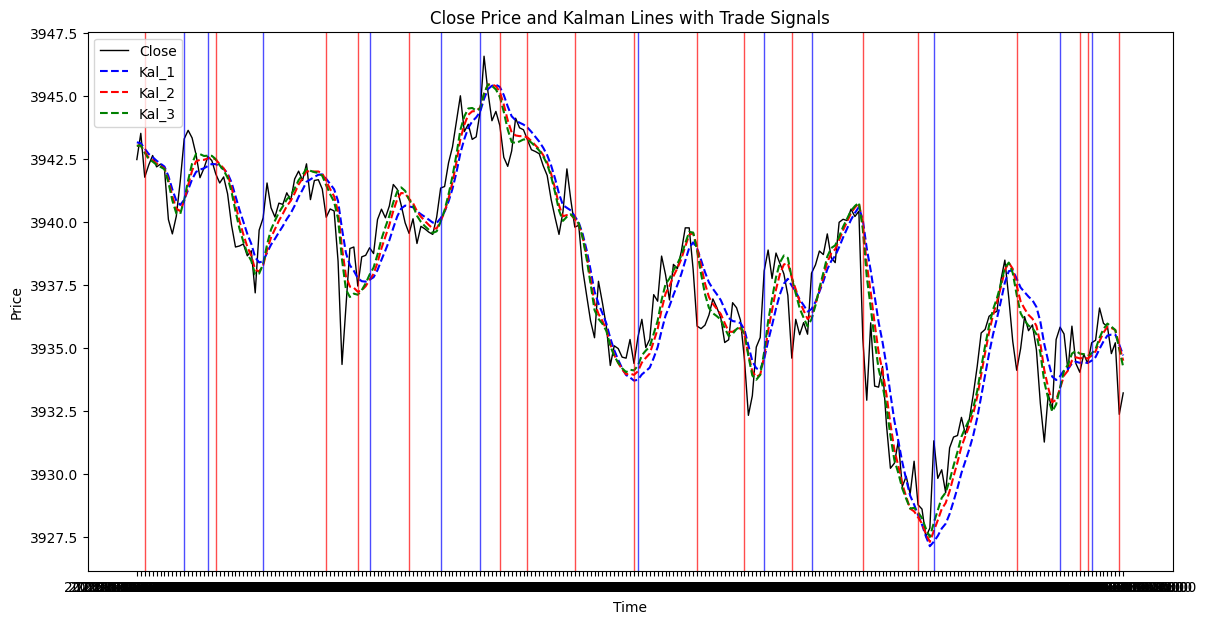

In [5]:
# Filter the DataFrame to include only the last 200 rows for plotting
df_plot = df.iloc[500:751].copy()

plt.figure(figsize=(14, 7))
plt.plot(df_plot['time'], df_plot['close'], label='Close', color='black', linewidth=1)
plt.plot(df_plot['time'], df_plot['kal_1'], label='Kal_1', color='blue', linestyle='--')
plt.plot(df_plot['time'], df_plot['kal_2'], label='Kal_2', color='red', linestyle='--')
plt.plot(df_plot['time'], df_plot['kal_3'], label='Kal_3', color='green', linestyle='--')

# Add vertical lines for trade signals
for index, row in df_plot.iterrows():
    if row['Open_Trade'] == 1:
        plt.axvline(row['time'], color='blue', linestyle='-', linewidth=1, alpha=0.7, label='Buy Signal' if row['time'] == df_plot['time'].iloc[0] else "")
    elif row['Open_Trade'] == -1:
        plt.axvline(row['time'], color='red', linestyle='-', linewidth=1, alpha=0.7, label='Sell Signal' if row['time'] == df_plot['time'].iloc[0] else "")

plt.title('Close Price and Kalman Lines with Trade Signals')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()